## Results

## Training RL agents

2024-03-26 17:17:35.290 WARNING legend - _parse_legend_args: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


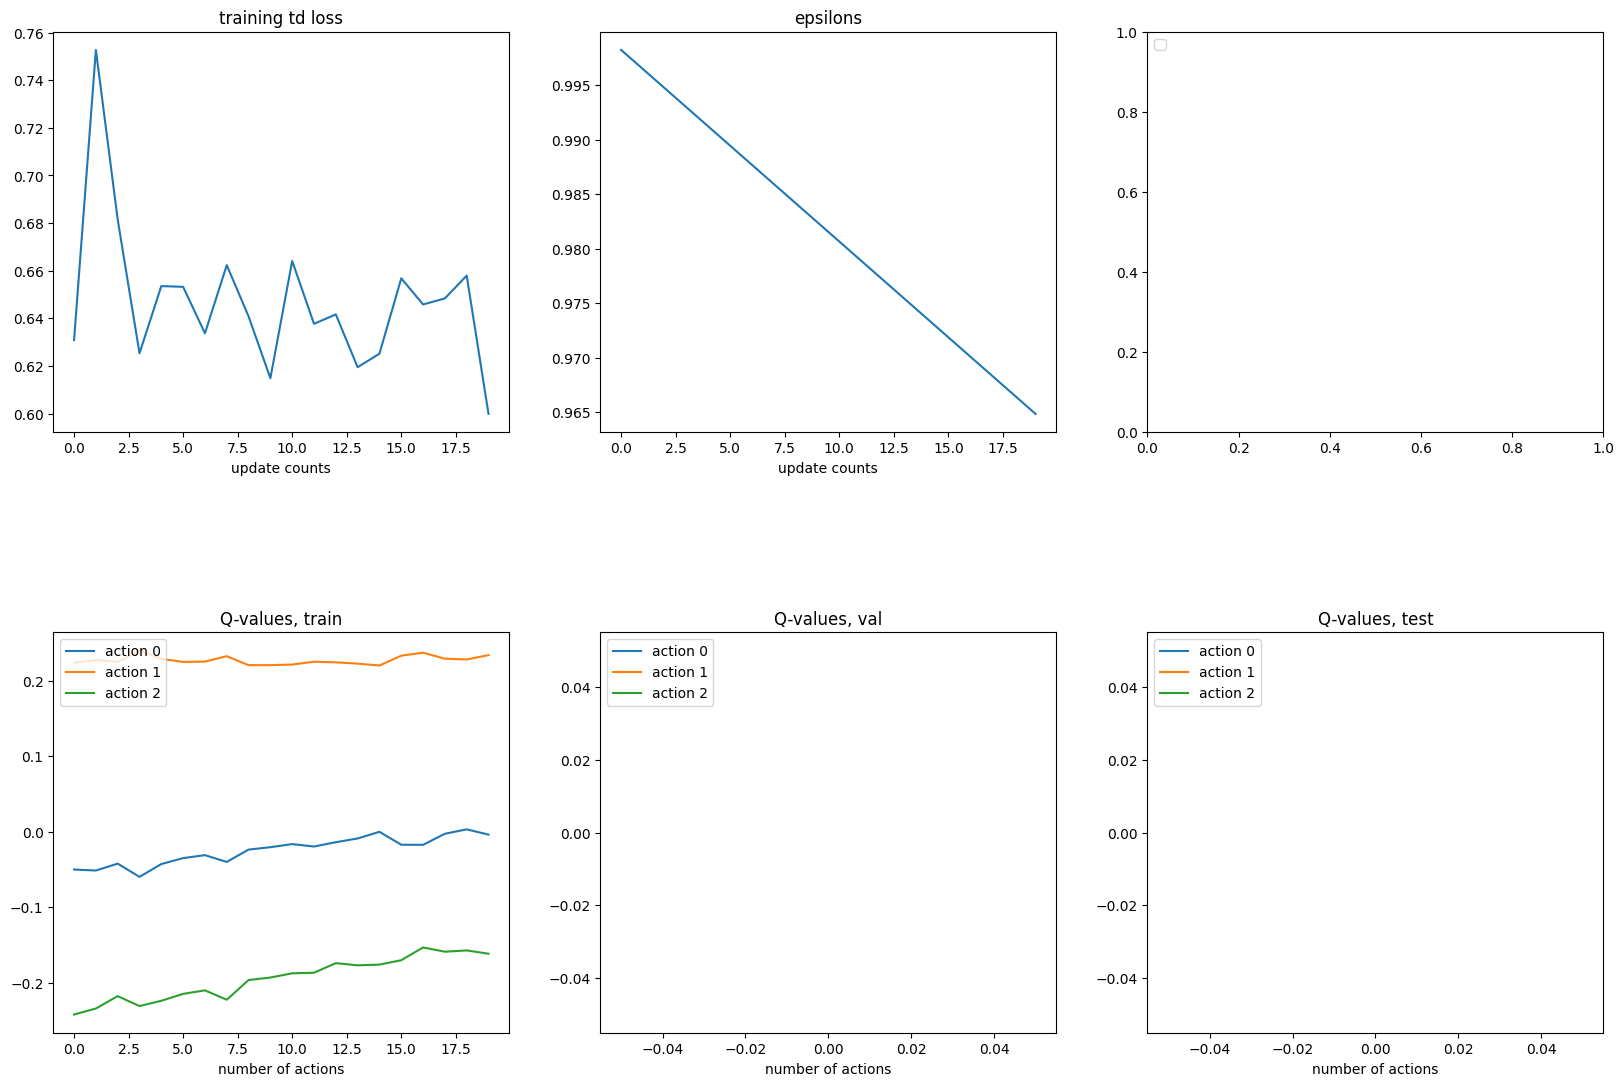

  5%|▌         | 28/512 [00:01<00:20, 24.14it/s]

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

params = {
    "env_str": "room_env:RoomEnv-v1",
    "env_config": {
        "des_size": "xxs",
        "question_prob": 1.0,
        "allow_random_human": False,
        "allow_random_question": False,
        "check_resources": True,
    },
    "num_iterations": 128 * 4,
    "epsilon_decay_until": 128 * 4,
    "replay_buffer_size": 128 * 2,
    "warm_start": 128 * 1,
    "batch_size": 32,
    "target_update_interval": 10,
    "max_epsilon": 1.0,
    "min_epsilon": 0.1,
    "gamma": 0.9,
    "capacity": {
        "episodic": 2,
        "semantic": 2,
        "short": 1,
    },
    "pretrain_semantic": False,
    "nn_params": {
        "hidden_size": 8,
        "num_layers": 2,
        "embedding_dim": 8,
        "include_human": "sum",
        "human_embedding_on_object_location": False,
        "fuse_information": "sum",
        "include_positional_encoding": True,
        "max_timesteps": 128,
        "max_strength": 128,
    },
    "run_test": True,
    "num_samples_for_results": 10,
    "plotting_interval": 10,
    "train_seed": 5,
    "test_seed": 0,
    "device": "cpu",
    "ddqn": False,
    "dueling_dqn": False,
    "default_root_dir": f"./training_results/DQN/TRASH",
}
agent = DQNAgent(**params)
agent.train()
agent.remove_results_from_disk()

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

from copy import deepcopy
import random

from tqdm.auto import tqdm

from agent import DQNAgent


train_configs = []

for _ in range(1000):
    warm_start = random.choice([128 * 2, 128 * 4, 128 * 8, 128 * 16])
    replay_buffer_size = random.choice(
        [warm_start, warm_start * 2, warm_start * 4, warm_start * 8]
    )
    replay_buffer_size = min(replay_buffer_size, 128 * 16)

    params = {
        "env_str": "room_env:RoomEnv-v1",
        "env_config": {
            "des_size": "l",
            "question_prob": 1.0,
            "allow_random_human": False,
            "allow_random_question": False,
            "check_resources": True,
        },
        "num_iterations": 128 * 16,
        "epsilon_decay_until": 128 * 16,
        "replay_buffer_size": replay_buffer_size,
        "warm_start": warm_start,
        "batch_size": random.choice([32, 64, 128, 256]),
        "target_update_interval": 10,
        "max_epsilon": 1.0,
        "min_epsilon": 0.1,
        "gamma": random.choice([0.5, 0.75, 0.9]),
        "capacity": {
            "episodic": 16,
            "semantic": 16,
            "short": 1,
        },
        "pretrain_semantic": False,
        "nn_params": {
            "hidden_size": 64,
            "num_layers": 2,
            "embedding_dim": 64,
            "v1_params": {
                "include_human": "sum",
                "human_embedding_on_object_location": False,
            },
            "v2_params": None,
            "fuse_information": "sum",
            "include_positional_encoding": True,
            "max_timesteps": 128,
            "max_strength": 128,
        },
        "run_test": True,
        "num_samples_for_results": 10,
        "plotting_interval": 10,
        "train_seed": 5,
        "test_seed": 0,
        "device": "cpu",
        "ddqn": random.choice([True, False]),
        "dueling_dqn": random.choice([True, False]),
        "default_root_dir": f"./training_results/DQN",
    }
    train_configs.append(deepcopy(params))

random.shuffle(train_configs)
for params in tqdm(train_configs):
    agent = DQNAgent(**params)
    agent.train()

    del agent

## Testing hand-crafted agents

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

import numpy as np

from tqdm.auto import tqdm

from agent import HandcraftedAgent

for policy in tqdm(["random", "episodic_only", "semantic_only"]):
    results = []
    for test_seed in [0, 1, 2, 3, 4]:
        params = {
            "env_config": {
                "des_size": "l",
                "question_prob": 1.0,
                "allow_random_human": True,
                "allow_random_question": True,
                "check_resources": True,
                "seed": test_seed,
            },
            "env_str": "room_env:RoomEnv-v1",
            "policy": policy,
            "num_samples_for_results": 10,
            "pretrain_semantic": False,
            "default_root_dir": "./training_results/TRASH/",
        }
        if policy == "random":
            params["capacity"] = {"episodic": 16, "semantic": 16, "short": 1}
        elif policy == "episodic_only":
            params["capacity"] = {"episodic": 32, "semantic": 0, "short": 1}
        else:
            params["capacity"] = {"episodic": 0, "semantic": 32, "short": 1}

        agent = HandcraftedAgent(**params)
        agent.test()
        agent.remove_results_from_disk()

        results.append(np.mean(agent.scores))
    print(policy, np.mean(results), np.std(results))